# 3D Brain tissue segmentation

Source:

Multiple parts of code were copied from https://www.kaggle.com/code/aileenliunew3/final-version-of-bme-dept-project#kln-184


Kaggle dataset:
https://www.kaggle.com/datasets/soroush361/3dbraintissuesegmentation

Original dataset:

DLBS https://fcon_1000.projects.nitrc.org/indi/retro/dlbs.html

IXI https://brain-development.org/ixi-dataset/

SALD http://fcon_1000.projects.nitrc.org/indi/retro/sald.html

In [1]:
#1: import packages
import sys, os
import glob
import math

import numpy as np
import pandas as pd
import skimage.transform as skTrans
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import scipy.interpolate as scInterp
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

cuda = torch.cuda.is_available()
print ("GPU available:", cuda)

# !rm -r test train valid

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GPU available: True


In [2]:
# #all code for preprocessing of 3d nii files into 2d np arrays
# #ran all the code, saved output, added it as input to this project under the dataset "aoe-bme-2d-arrays"
# #have commented out this code so I don't accidentally run it all again

# # #check number of nii files in each set 
# # !ls /kaggle/input/3dbraintissuesegmentation/test/image/*.nii | wc -l
# # !ls /kaggle/input/3dbraintissuesegmentation/train/image/*.nii | wc -l
# # !ls /kaggle/input/3dbraintissuesegmentation/valid/image/*.nii | wc -l

# def clear_files(folder):
#     files = glob.glob(os.path.join(folder, "*"))
#     for file in files:
#         os.remove(f)

# root_folder = "/kaggle/input/3dbraintissuesegmentation"
# output_folder = "/kaggle/working"

# !rm -r test train valid
# !mkdir test train valid

# def addPadding(array):
#     """
#     add padding to image so its dimensions are 224x224 since it's divisible by 2^4 (there's four layers with down convolutions)
#     """
#     diff = [0, 224-array.shape[1], 224-array.shape[2], 224-array.shape[3]]
#     padded_array = np.pad(array, ((0, 0), (diff[1]//2, math.ceil(diff[1]/2)), (diff[2]//2, math.ceil(diff[2]/2)), (diff[3]//2, math.ceil(diff[3]/2))))
#     return padded_array

# def NiftyToNp(root_folder, folder, output_folder):  # folder can be 'test', 'train' or 'valid'
#     """ convert NIfTI file to numpy array """
#     folder_path = os.path.join(root_folder, folder) #path for train folder, for example
#     img_folder_path = os.path.join(folder_path, 'image') #path for train image folder, for example
#     mask_folder_path = os.path.join(folder_path, 'mask') #path for train mask folder, for example
#     output_folder_path = os.path.join(output_folder, folder)
#     sbj_list = [i.split("_img.nii")[0] for i in os.listdir(img_folder_path) if i.endswith(".nii")] #use the image folder to get all the subject IDs
#     # ['sald_031433', 'dlbs_0028553', 'dlbs_0028476','sald_031371','dlbs_0028561',..]
#     for sbj in sbj_list:
#         print (f"currently processing {sbj} in {folder}, {sbj_list.index(sbj)+1} of {len(sbj_list)}          ", end = "\r")
#         img = nib.load(os.path.join(img_folder_path, sbj + "_img.nii")).get_fdata() #load data for subject's MRI
#         original_img_shape = img.shape
#         img = (img-img.min())/(img.max()-img.min()) #scale to [0, 1] -> don't need to do the same for the masks because they're binary as is
        
#         # img.shape was (182, 218, 182)
#         #pad and resize image
#         img = addPadding(np.expand_dims(img, axis = 0)) # shape (1, 224, 224, 224)
#         img = skTrans.resize(img, (1, 112, 112, 112), order = 1, preserve_range = True) # shape (1, 112, 112, 112)
        
#         mask_csf = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_csf.nii")).get_fdata()
#         mask_gm = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_graymatter.nii")).get_fdata()
#         mask_wm = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_whitematter.nii")).get_fdata()
        
#         mask = np.zeros(((4,) + original_img_shape)) #combine all the masks into one 4D array 
#         mask[1] = mask_csf
#         mask[2] = mask_gm
#         mask[3] = mask_wm
        
#         #pad and resize mask
#         mask = addPadding(mask)
#         mask[0, np.logical_and.reduce((mask[1] == 0, mask[2] == 0, mask[3] == 0))] = 1.0 # pixel in mask[0] is 1 when and only when all corresponding values in masks are 0 - i.e. it is background
#         mask = skTrans.resize(mask, (4, 112, 112, 112), order = 1, preserve_range = True)
        
#         possible_range = [i for i in range(0, img.shape[1]) if np.sum(mask[0,i,:,:]) != 12544] # 112**2
        
#         #run this whole loop 3x, changing i in img.shape[i] and location of idx in img[idx,:,:] each time
#         #create image slices, but only every 7 slices because memory limitations on kaggle
#         #112 is divisible by 7 (7x16 = 112), and we can remove the first and last arrays (which contain essentially nothing)
#         for idx in range(possible_range[0] + 1, possible_range[-1] + 1, 7):
            
#             img_slc = img[:,idx,:,:]
#             mask_slc = mask[:,idx,:,:]
            
# #             plot_image(mask_slc, img_slc, idx)
            
#             #save image and mask slices
#             np.save(os.path.join(output_folder_path, f"{sbj}_slc{idx:03}_img.npy"), img_slc)
#             np.save(os.path.join(output_folder_path, f"{sbj}_slc{idx:03}_mask.npy"), mask_slc)

# def numberOfItemsInFolder(folder):
#     listofItems = glob.glob(os.path.join(folder, "*"))
#     return (len(listofItems))

# #process each folder
# folders = ['test', 'train', 'valid']
# for curr_folder in folders:
#     NiftyToNp(root_folder, curr_folder, output_folder)
    
# #check for correct number of items in each folder
# for curr_folder in folders:
#     print (f"{curr_folder} has {numberOfItemsInFolder(os.path.join(output_folder, curr_folder))} items \n")

In [3]:
masks = ["background", "csf", "gm", "wm"]

def plot_image(mask_array, image_array, idx, axis, save_root_folder = None):
    """
    check that images were all processed correctly
    """
    plt.figure(figsize = (22,22))
    plt.subplot(1, 5, 1)
    plt.title(f"{idx} image on Axis {axis}")
    plt.imshow(image_array[0], cmap = "gray")
    
    for i in range(len(masks)):
        show_image = mask_array[i]
        plt.subplot(1, 5, i +2)
        plt.title (f"{idx} {masks[i]} on Axis {axis}")
        plt.imshow(show_image, cmap = "gray")
        plt.axis("off")
    plt.tight_layout()
    if save_root_folder:
        plt.savefig(os.path.join(save_root_folder, f"Axis_{axis}_{idx}_Images_And_Masks.png"))
    plt.show() 

In [4]:
class BasicDataset(TensorDataset):
    def __init__(self, root_folder, folder, percent_samples=None): #set percent_samples lower if you just want to evaluate
        self.folder = os.path.join(root_folder, folder)
        self.img_sbj_list = sorted([i.split("_img.npy")[0] for i in os.listdir(self.folder) if i.endswith("img.npy")]) #get all image subject IDs
        self.mask_sbj_list = sorted([i.split("_mask.npy")[0] for i in os.listdir(self.folder) if i.endswith("mask.npy")]) #get all mask subject IDs

        #check that there's the right number of mask and image files
        assert self.img_sbj_list == self.mask_sbj_list, f"Mask and Image File Numbers don't match in {folder} folder"

        if not percent_samples or percent_samples > len(self.img_sbj_list): #if n_sample isn't set by user
            # NO - NOT THIS___percent_samples = len(self.img_sbj_list)
            percent_samples = 1.0

        self.n_samples = int(len(self.img_sbj_list) * percent_samples)
        self.ids = self.img_sbj_list[0: self.n_samples] # id is a part of file name
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, i):
        # generates one sample of data
        idx = self.ids[i]

        img = np.load(os.path.join(self.folder, idx + "_img.npy")) #expand img dims so it's a 3d array, like the masks
        mask = np.load(os.path.join(self.folder, idx + "_mask.npy"))

        #lets you do basicdataset[i]['image']
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'img_id': i,
            'sbj_id':self.img_sbj_list[i]
        }

In [5]:
class DoubleConv(nn.Module):
    """ 2d conv with normalization and ReLu activation layers"""
    # inspired by https://www.kaggle.com/code/aileenliunew3/final-version-of-bme-dept-project and
        # https://www.kaggle.com/code/aimlabb/tumorsegmenter/notebook
    def __init__(self, in_chans, out_chans):
        super().__init__()
        self.bloc = nn.Sequential (
            nn.Conv2d(in_chans, out_chans, kernel_size = 3, padding = "same"),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace = True), # memory saving
            nn.Conv2d(out_chans, out_chans, kernel_size = 3, padding = "same"), # note input shape
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        return self.bloc(x)


class DownConv(nn.Module):
    """conv -> ReLU -> MaxPool """
    def __init__(self, in_chans, out_chans):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_chans, out_chans)
        )
        

    def forward(self, x):
        return self.encoder(x)


class UpConv(nn.Module):
    """ upsample -> conv -> concatenate with cropped earlier layer -> DoubleConv"""
    # Consists of 2x2 transposed convolution -> Conv -> relu
    def __init__(self, in_chans, out_chans):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode = "bilinear", align_corners=True),
            nn.Conv2d(in_chans, out_chans, kernel_size = 1),
        )
        self.conv = DoubleConv(out_chans*2, out_chans) # in_chans=2*out_chans because we concat new and previous vectors

    def forward(self, x_new, x_prev):
        x_new = self.up(x_new) 
        x = torch.cat([x_new, x_prev], dim=1) # concatenate along channel axis s.t. the number of channels is doubled
        x = self.conv(x)
        return x
    
class OutputLayer(nn.Module):
    """ 1x1 conv -> softmax (to get probabilities) """
    def __init__(self, in_chans, out_chans):
        super().__init__()
        self.outputLayer = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=1),
            nn.Softmax(dim = 1) # sum of each slice along channel (mask) axis is 1
        )

    def forward(self, x):
        return self.outputLayer(x)

UNet

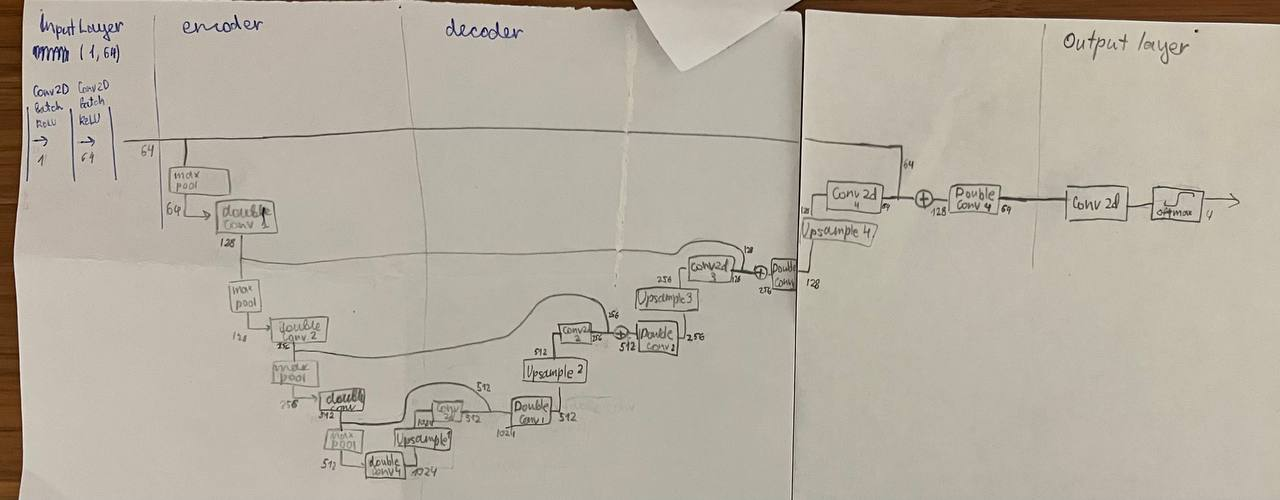

In [6]:
### define class UNet ###

class UNet(nn.Module):
    """
    encode -> concatenate -> decode
    """

    def __init__(self, name, n_chans, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_chans = n_chans
        self.n_classes = n_classes

        out_chans = 64
        self.inputLayer = DoubleConv(n_chans, out_chans)

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        in_chans = out_chans
        out_chans = out_chans*2

        for _ in range(4): # 4 hidden layers converting spatial information into feature info
            self.encoder.append(DownConv(in_chans, out_chans))
            in_chans, out_chans = out_chans, out_chans*2
        """
        64 128
        128 256
        256 512
        512 1024
        current var values: in=1024 out=2048
        """

        out_chans = in_chans // 2 # out=512

        for _ in range(4): # 4 hidden layers converting feature information into spatial info
            self.decoder.append(UpConv(in_chans, out_chans))
            in_chans, out_chans = out_chans, out_chans // 2
        """
        1024 512
        512 256
        256 128
        128 64
        cur var values: in=64 out=32
        """

        out_chans = in_chans

        self.outputLayer = OutputLayer(out_chans, n_classes)
    
    def forward(self, x):
        x = self.inputLayer(x)
        encoded = []
        for enc in self.encoder:
            encoded.append(x)
            x = enc(x)
        encoded.append(x)
        # encoded = [x(input_layer), enc1, enc2, enc3, enc4]
        
        x = encoded.pop()
        for dec in self.decoder:
            x = dec(x, encoded.pop())
        # dec1 = dec(enc4, enc3)
        # dec2 = dec(dec1, enc2)
        # dec3 = dec(dec2, enc1)
        # dec4 = dec(dec3, x(input_layer))
        
        x = self.outputLayer(x)
        
        return x

In [7]:
def loss_function(criterion, images, model_output, gt_masks, mode):
    """
    calculate loss for the three tissue type channels only over the brain area
    compute loss for background channel over the whole area
    """
    
    if mode == "val":
        torch.manual_seed(1102)
        np.random.seed(1102)
        
    #remove extra dimension
    images_squeezed = torch.squeeze(images, dim = 1) # channel dim is 1?
    
    #turn this into binary brain map (values are 1 where brain, 0 where background)
    brain_map = (images_squeezed > 0).float()
    
    #stack the brain maps so their shape is batch_size x 4 x 112 x 112 (like model's output)
    #computing loss for background channel over the whole area, so that will just be filled with ones 
    ones = torch.ones((brain_map.shape)).cuda()
    stacked_brain_map = torch.stack(([ones, brain_map, brain_map, brain_map]), dim = 1)
    
    #only consider the values inside the brain (zero out others using 0s in bg of stacked brain map)
    isolated_images = torch.mul(stacked_brain_map, model_output)
    
    #see how the probabilities at each (prediction vs ground truth) compare using whatever criterion you prefer
    #computes avg loss over all the brain voxels
    loss = criterion(isolated_images, gt_masks) #make sure reduction = "sum" so you can do average over entire brain area
    num_brain_voxels = stacked_brain_map.sum()
    loss = loss / num_brain_voxels
    
    #return the isolated_images and the stacked_brain_map too because they're helpful for other functions
    return loss, isolated_images, stacked_brain_map
    
def pearson_coeff(isolated_image, target, stacked_brain_map):
    """
    calculate pearson correlation coefficient over the brain area
    """
    #flatten so you can do pearson correlation calculation
    gt_flattened = torch.flatten(target)
    iso_flattened = torch.flatten(isolated_image)
    mask_flattened = torch.flatten(stacked_brain_map)
    
    #only keep the values where there is brain (like not just zero them out, but discard them)
    gt_flattened = gt_flattened[mask_flattened.nonzero(as_tuple = True)]
    iso_flattened = iso_flattened[mask_flattened.nonzero(as_tuple = True)]
    
    #remove from cupa and turn tensor into numpy array
    iso_flattened = iso_flattened.cpu().detach().numpy()
    gt_flattened = gt_flattened.cpu().detach().numpy()
    
    #calculate and return pearson correlation coefficient
    pearson = np.corrcoef(iso_flattened, gt_flattened)[0][1]
    return pearson

In [8]:
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    #create folder to model in (if not already existing)
    if not os.path.isdir(f'{net.name}'):
        os.mkdir(f'{net.name}')
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = []
    train_pearson = []
    
    valid_loss = []
    valid_pearson = []
    
    #TRAINING
    for epoch in range(epochs):
        net.train() # set mode to 'train'; this change behavior of batch normalization and dropout
        
        train_batch_loss = []
        train_batch_pearson = []
        
        for i, batch in enumerate(train_dataloader):
            
            #load image and gt mask for the batch and mount to cupa 
            imgs = batch['image'].cuda()
            masks = batch['mask'].cuda()

            #load model prediction w/ current weights
            pred = net(imgs)

            #compute batch loss and append to overall training loss
            loss, isolated_images, stacked_brain_map = loss_function(criterion, imgs, pred, masks, 'train')
            batch_loss = loss.item() #this just turns it into a number instead (i think it was a tensor)
            train_batch_loss.append(batch_loss)

            #compute batch's pearson coeff and append to overall
            batch_pearson = pearson_coeff(isolated_images, masks, stacked_brain_map)
            train_batch_pearson.append(batch_pearson)

            optimizer.zero_grad() #reset gradient values
            loss.backward() #compute backwards loss
            optimizer.step() #update weights
            
            #update progress (bc the end = '\r' rewrites over the last!)
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, Pearson Coefficient: {batch_pearson}', end='\r')
        
        #calculate averages and append to overall
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_pearson = np.array(train_batch_pearson).mean()

        train_loss.append(average_training_loss)
        train_pearson.append(average_training_pearson)
        
        #VALIDATION
        net.eval() # set mode to 'eval'
        valid_batch_loss = list()
        valid_batch_pearson = list()
        
        #don't calculate gradient since you're not trying to train here, just evaluate
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                #load image and mask for batch, mount to cupa
                imgs = batch['image'].cuda()
                masks = batch['mask'].cuda()

                #load model prediction w/ current weights
                pred = net(imgs)

                # compute batch loss and append to overall validation loss
                loss, isolated_images, stacked_brain_map = loss_function(criterion, imgs, pred, masks, 'val')
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                #compute batch's pearson coeff and append to overall validation loss
                batch_pearson = pearson_coeff(isolated_images, masks, stacked_brain_map)
                valid_batch_pearson.append(batch_pearson)

                #update progress (bc the end = '\r' rewrites over the last!)
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, Pearson Coefficient: {batch_pearson}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_pearson = np.array(valid_batch_pearson).mean()
        valid_loss.append(average_validation_loss)
        valid_pearson.append(average_validation_pearson)
        
        #print final evaluation of epoch 
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training Pearson score: {average_training_pearson}, Validation Loss: {average_validation_loss}, Validation Pearson Coefficient: {average_validation_pearson}')

        #save model 
        #note: since there's only 50 epochs you can change to {:02}
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_pearson, valid_loss, valid_pearson

In [9]:
def dice_coeff_CM(isolated_image, target, stacked_brain_map):
    """
    calculate dice coefficient to evaluate model in testing stage and also return confusion matrix
    literally just convenient to do them together since they need the same inputs and you only need either for the testing stage
    not going to include bacground in calcations because there is so much background, it'll make the dice score higher than it should be
    """
    
    #create dictionary for each channel
    #ie. gt1 would csf, 2 gm, 3 wm
    masks_list = ["gt1", "gt2", "gt3", "iso1", "iso2", "iso3"]
    masks_dict = {i :{} for i in masks_list}
    
    #create maps with values of 0, 1, 2, 3, depending on which tissue type is the most likely to exist there (max value)
    #reminder: 0 is background here

    full_map_model = torch.argmax(isolated_image, 1) 
    full_map_gt = torch.argmax(target, 1)
    #shape of these is batch_size x 122 x 122
    
#     #don't consider background channel in dice score calculations / confusion matrix
#     full_map_model = full_map_model[:,[1, 2, 3],:, :]
#     full_map_gt = full_map_gt[:,[1, 2, 3], :, :]
    
    #binary_brain is a batch_size x 122x122 array that is 0 where background, 1 where brain
    #brain_flattened is 1d version of that
    binary_brain = stacked_brain_map[:,1,:,:]
    brain_flattened = torch.flatten(binary_brain)
     
    #okay quick pause for confusion matrix calculations
    
    #flatten because that's needed for CM calculations
    CM_full_map_model = torch.flatten(full_map_model)
    CM_full_map_gt = torch.flatten(full_map_gt)
    
    #detach from cupa and turn into numpy arrays for CM calculation
    CM_full_map_model = CM_full_map_model.cpu().detach().numpy()
    CM_full_map_gt = CM_full_map_gt.cpu().detach().numpy()
    CM = confusion_matrix(CM_full_map_gt, CM_full_map_model)
    
    #okay back to dice_scores
    dice_scores = []
    
    #calculate one dice score for each tissue type
    for i in range (1, 4):
        #key is a tensor where 0 if not correct tissue type (background or other tissue), 1 if correct tissue type
        masks_dict["gt" + str(i)] = (full_map_gt == i).float()
        masks_dict["iso" + str(i)] = (full_map_model == i).float()
            
        #make flattened numpy arrays that only contain within-brain mask values (background values taken out)
        masks_dict["gt" + str(i)] = torch.flatten(masks_dict["gt" + str(i)])
        masks_dict["gt" + str(i)] = masks_dict["gt" + str(i)][brain_flattened.nonzero(as_tuple = True)]
        masks_dict["gt" + str(i)] = masks_dict["gt" + str(i)].cpu().detach().numpy()
        
        masks_dict["iso" + str(i)] = torch.flatten(masks_dict["iso" + str(i)])
        masks_dict["iso" + str(i)] = masks_dict["iso" + str(i)][brain_flattened.nonzero(as_tuple = True)]
        masks_dict["iso" + str(i)] = masks_dict["iso" + str(i)].cpu().detach().numpy()
    
        #okay wait actually none of the mask_dict stuff is really necessary since you're not accessing the dictionaries later...
        #like you're literally taking these values and assigning them new names...
        #note: come back and delete all the dictionary stuff... literally just give them the below names from the beginning
        model_output = masks_dict["iso" + str(i)]
        gt = masks_dict["gt" + str(i)]
        eps = 0.00001 #so there's no dividing by zero
        
        #calculate dice scores and append to overall dice scores list
        dice = (np.sum(model_output[gt == 1]) * 2.0 + eps) / (np.sum(model_output) + np.sum(gt) + eps)
        dice_scores.append(dice)
    
    #calculate and return avg dice scores and confusion matrix info
    avg_dice = sum(dice_scores)/len(dice_scores)
    return avg_dice, CM

#TESTING
def test_net(net, test_dataloader, loss_function):
#     #COME BACK HERE, BOOKMARK
#     #make folder to save model predictions in but also are we saving those
#     if not os.path.isdir('/kaggle/working/pred_mask'):
#         os.mkdir('/kaggle/working/pred_mask')
        
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = []
    test_batch_pearson = []
    test_batch_dice = []
    test_batch_CM = []
    all_imgs = []
    all_labels = list()
    all_preds = list()
    
    #no need to update gradient
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            #load image and mask for batch, mount to cupa
            imgs = batch['image'].cuda()
            masks = batch['mask'].cuda()
            
            #load model prediction w/ "best" weights
            pred = net(imgs)
            
            #compute batch loss and append to overall validation loss
            loss, isolated_images, stacked_brain_map = loss_function(criterion, imgs, pred, masks, 'test')
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)
            
            #compute batch's pearson coeff and append to overall validation loss            
            batch_pearson = pearson_coeff(isolated_images, masks, stacked_brain_map)
            test_batch_pearson.append(batch_pearson)
            
            #compute batch's dice score and confusion matrix and append to overall lists
            batch_dice, batch_CM = dice_coeff_CM(isolated_images, masks, stacked_brain_map)
            test_batch_dice.append(batch_dice)
            test_batch_CM.append(batch_CM)
            
            pred = pred.cpu().detach().numpy()
            imgs = imgs.cpu().detach().numpy()
            labels = batch['sbj_id']
            all_labels+=labels
            all_preds.append(pred)
            all_imgs.append(imgs)
            

            #update progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, Pearson Corr: {batch_pearson}, DICE score: {batch_dice}', end='\r')
        
        #find averages of all metrics and return them
        test_loss = np.array(test_batch_loss).mean()
        test_dice = np.array(test_batch_dice).mean()
        test_pearson = np.array(test_batch_pearson).mean()
        test_CM = np.array(test_batch_CM).mean(axis = 0)
        
    return all_imgs, all_labels, all_preds, test_loss, test_dice, test_pearson, test_CM

In [10]:
def CM(test_CM, save_root_folder, label):
    """
    given CM values, return a nice little visualization of them :), but with the background values removed because there's too many 
    """
    
    #turn into panda dataframe so you can add labels!
    df_cm = pd.DataFrame(test_CM, index = ["Background", "CSF", "GM", "WM"],
                     columns = ["Background", "CSF", "GM", "WM"])
    
    #remove the background >:(
    df_cm.pop("Background")
    df_cm = df_cm.drop("Background", axis = "index")
    
    #plot 
    plt.figure(figsize = (12,10))
    plt.title('Confusion Matrix')
    sns.heatmap(df_cm, annot = True, annot_kws = {"size": 15})
    plt.ylabel('True labels')
    plt.xlabel('predicted labels')
    
    #save plot
    plt.savefig(os.path.join(save_root_folder, f"{label}_Confusion_Matrix.png"))
    plt.show()

def learning_curve(best_epoch, train_loss, valid_loss, train_pearson, valid_pearson, save_root_folder):
    """
    return visualization of how the metrics improved during each epoch (learning curve)
    """
    fig, (ax1, ax2) = plt.subplots(figsize = (15, 8), ncols = 2)
    fig.suptitle("Learning Curve", fontsize = 18)
        
    #plot losses on first graph
    ax1.set_ylabel("Loss", fontsize = 15)
    ax1.set_xlabel("Epoch", fontsize = 15)
    ax1.set_xticks(np.arange(EPOCHS, step = 10) + 1)
    ax1.plot(np.arange(EPOCHS) + 1, train_loss, '-o', label = "Training")
    ax1.plot(np.arange(EPOCHS) + 1, valid_loss, '-o', label = "Validation")
    ax1.axvline(best_epoch, color = 'm', lw = 4, alpha = 0.5, label = "Best Epoch") #highlight the best epoch
    
    #plot pearson coefficients on second graph    
    ax2.set_ylabel("Pearson Coeff", fontsize = 15)
    ax2.set_xlabel("Epoch", fontsize = 15)
    ax2.set_xticks(np.arange(EPOCHS, step = 10) + 1)
    ax2.plot(np.arange(EPOCHS) + 1, train_pearson, '-o', label = "Training")
    ax2.plot(np.arange(EPOCHS) + 1, valid_pearson, '-o', label = "Validation ")
    ax2.axvline(best_epoch, color = 'm', lw = 4, alpha = 0.5, label = "Best Epoch") #highlight the best epoch

    
    plt.legend()
    plt.tight_layout()
    
    #save plot
    plt.savefig(os.path.join(save_root_folder, "Learning_Curve.png"))
    plt.show()

Batches in Train DataLoader: 58
Batches in Validation DataLoader: 19
Batches in Test DataLoader: 20
EPOCH 1/50 - Training Loss: 0.1762689375158014, Training Pearson score: 0.6975693979991849, Validation Loss: 0.14191126588143801, Validation Pearson Coefficient: 0.8331163953056965
EPOCH 2/50 - Training Loss: 0.11154807924196639, Training Pearson score: 0.8704955131666476, Validation Loss: 0.09220134662954431, Validation Pearson Coefficient: 0.9007113534594907
EPOCH 3/50 - Training Loss: 0.07794912981575933, Training Pearson score: 0.9176426969180607, Validation Loss: 0.06669325812866814, Validation Pearson Coefficient: 0.9299899261345949
EPOCH 4/50 - Training Loss: 0.05910605789515479, Training Pearson score: 0.9365528746290033, Validation Loss: 0.052498983513367806, Validation Pearson Coefficient: 0.9433363452378712
EPOCH 5/50 - Training Loss: 0.047544315007740055, Training Pearson score: 0.9470990411317948, Validation Loss: 0.04317160284048632, Validation Pearson Coefficient: 0.951689

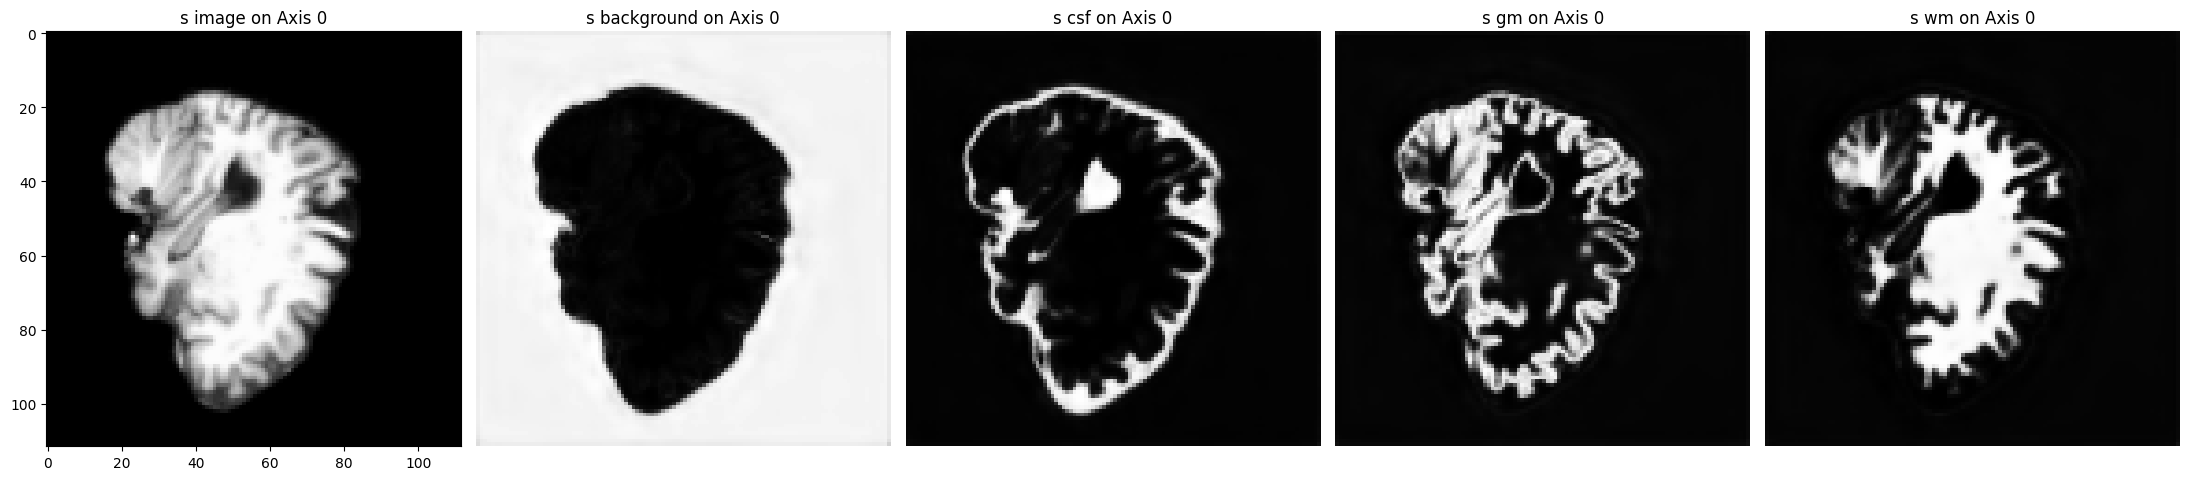

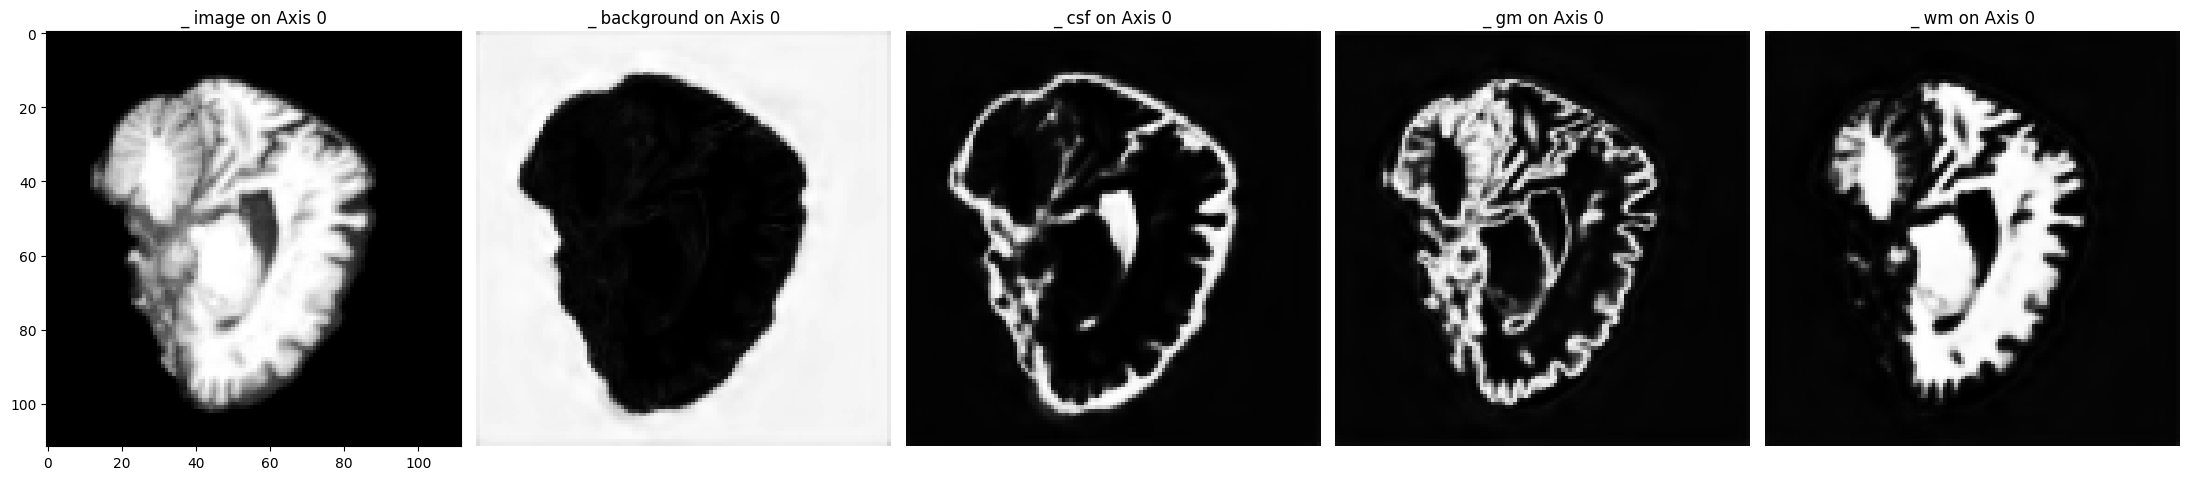

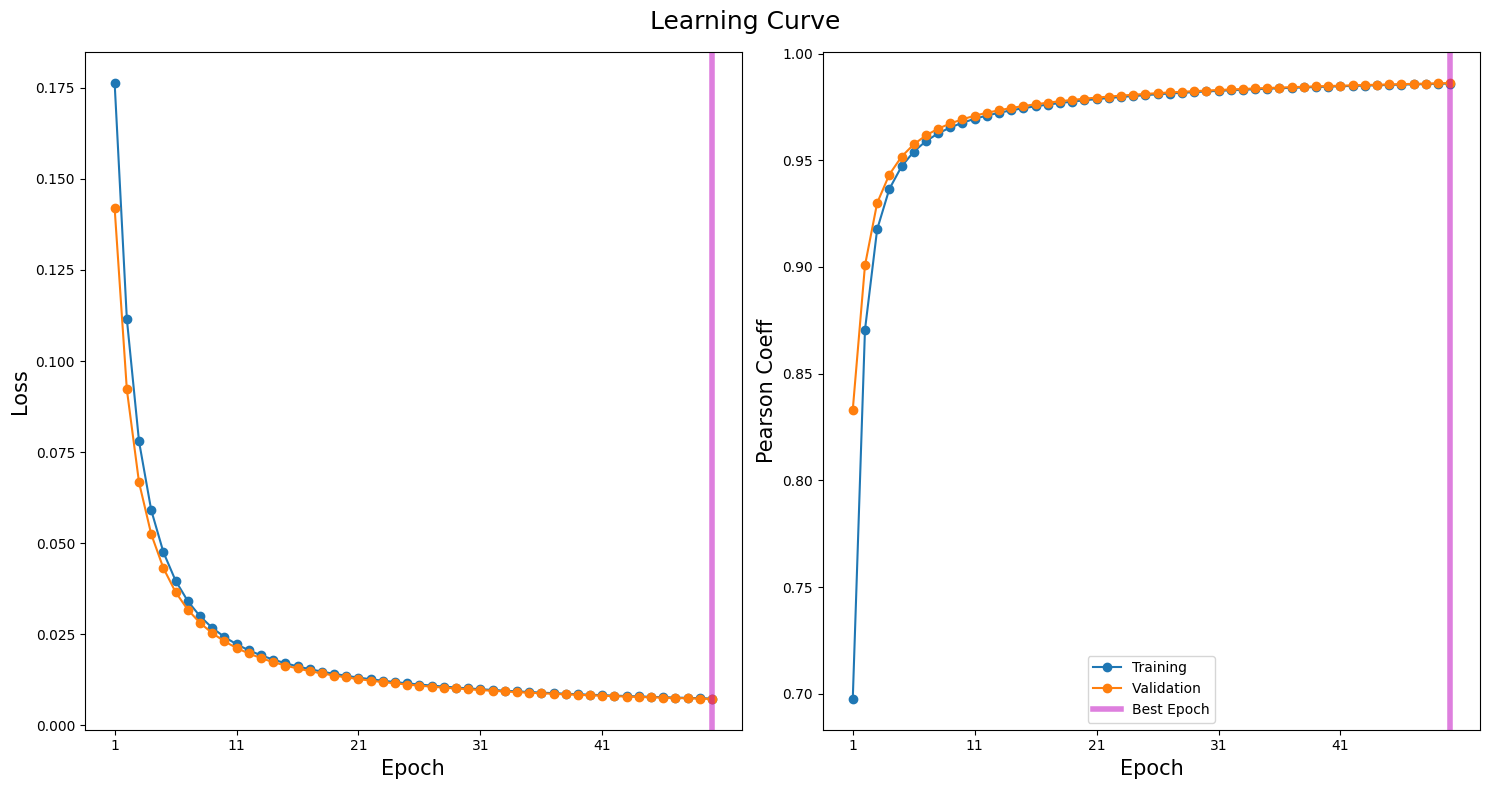

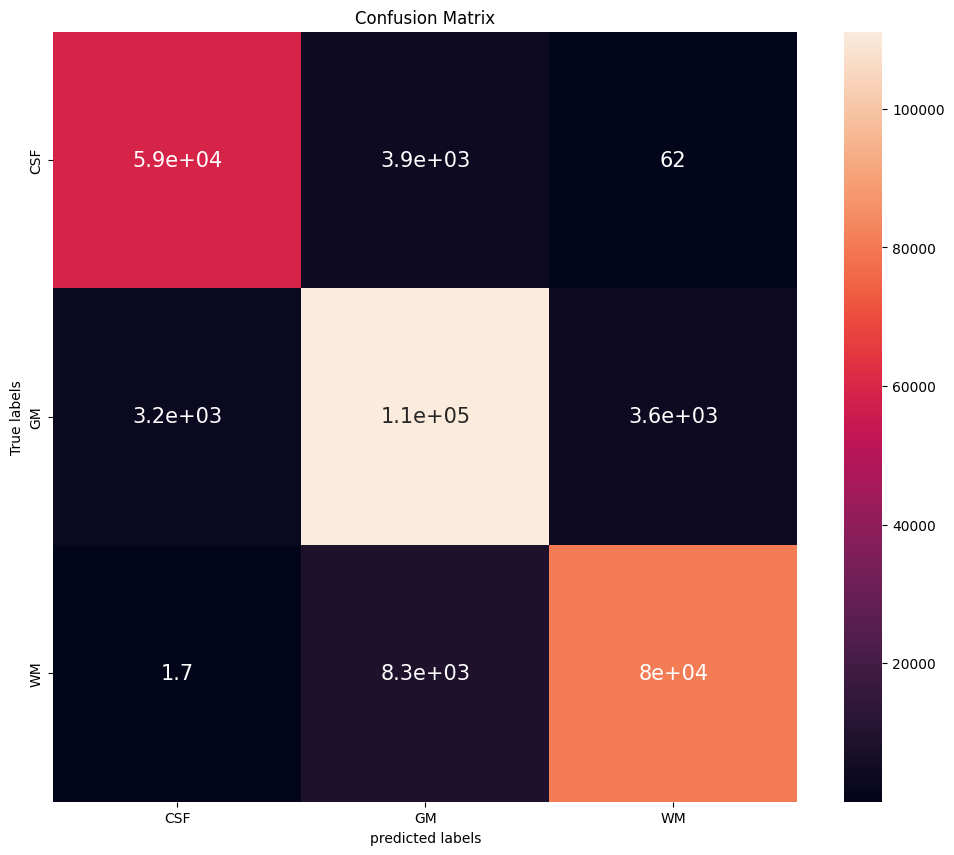

Batches in Train DataLoader: 72
Batches in Validation DataLoader: 24
Batches in Test DataLoader: 25
EPOCH 1/50 - Training Loss: 0.18993962928652763, Training Pearson score: 0.7142566639765054, Validation Loss: 0.13627838591734567, Validation Pearson Coefficient: 0.8579950326504019
EPOCH 2/50 - Training Loss: 0.1121925369112028, Training Pearson score: 0.8885267832964404, Validation Loss: 0.08962609432637691, Validation Pearson Coefficient: 0.9178893085422389
EPOCH 3/50 - Training Loss: 0.07480099838640955, Training Pearson score: 0.930377196989751, Validation Loss: 0.06267635291442275, Validation Pearson Coefficient: 0.9421188964122464
EPOCH 4/50 - Training Loss: 0.05466367992469006, Training Pearson score: 0.9472319937145282, Validation Loss: 0.047715057929356895, Validation Pearson Coefficient: 0.9535972062905035
EPOCH 5/50 - Training Loss: 0.042794499856730304, Training Pearson score: 0.956460532926908, Validation Loss: 0.03832341699550549, Validation Pearson Coefficient: 0.96066864

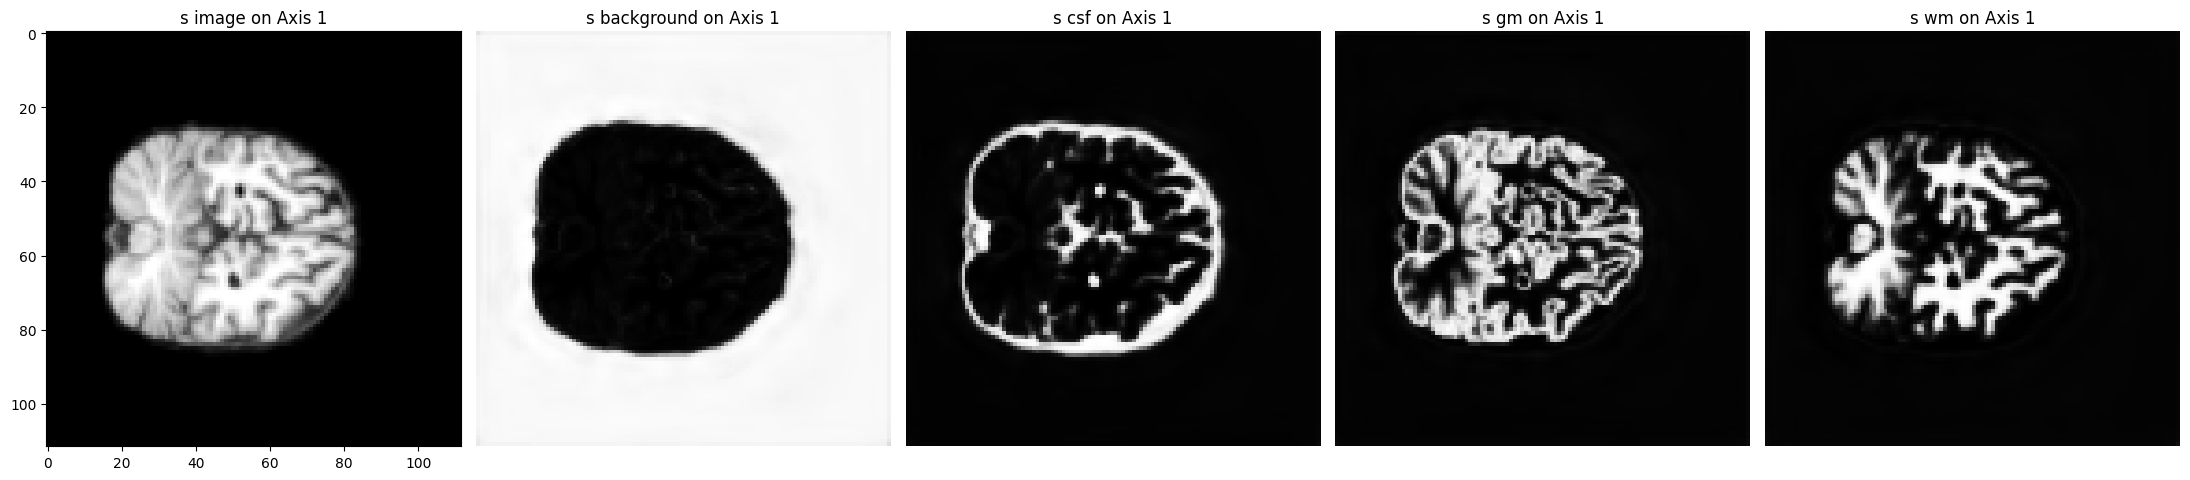

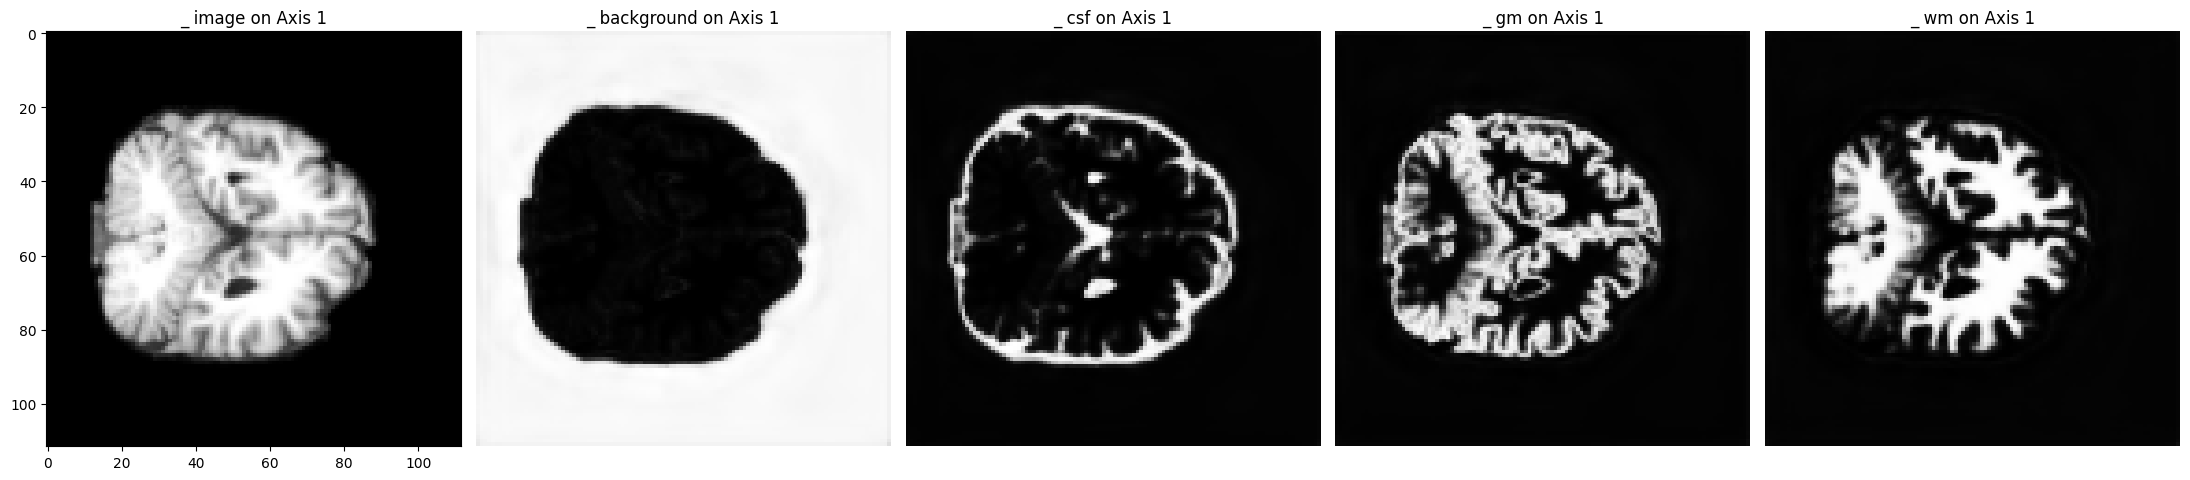

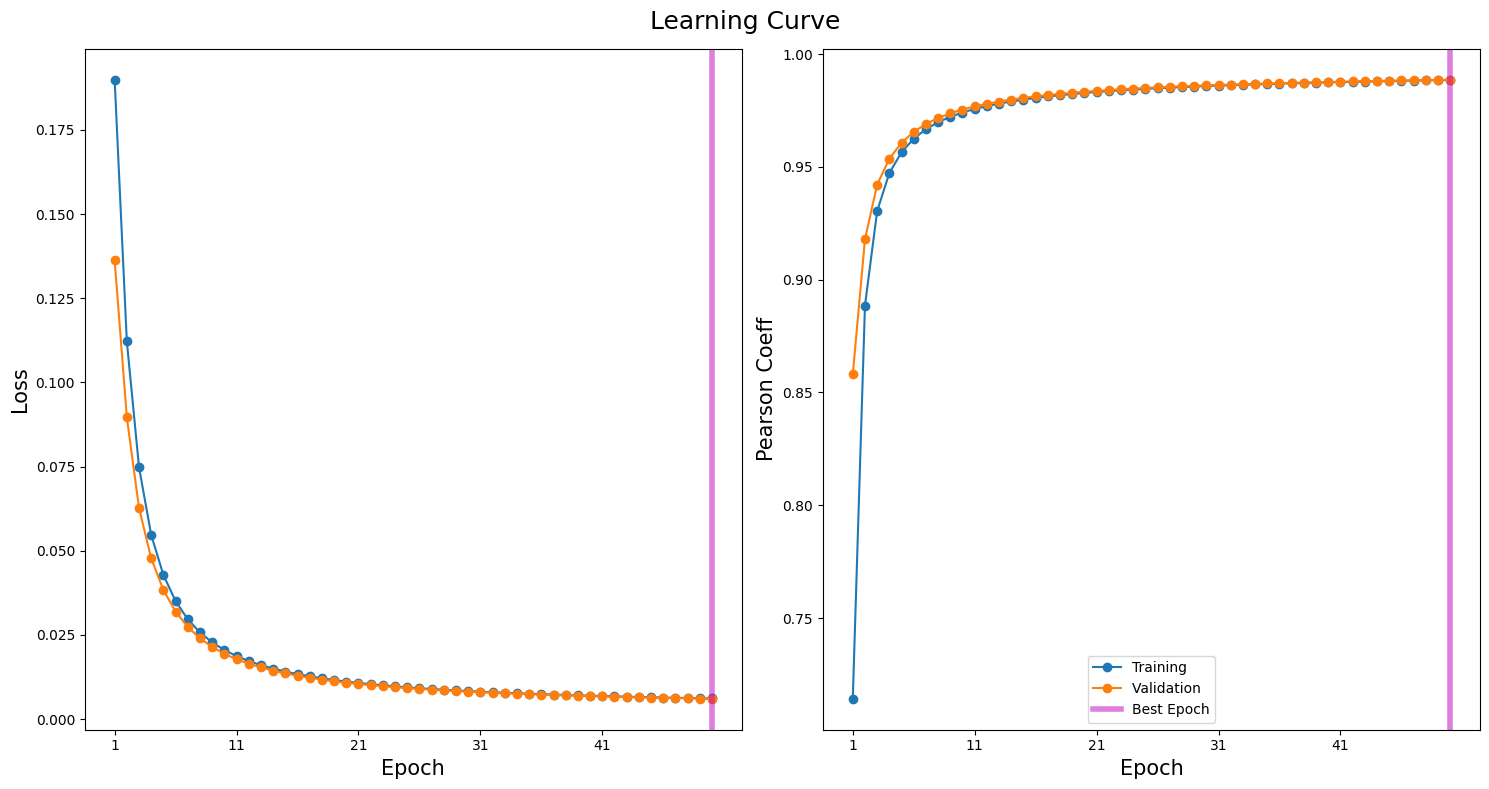

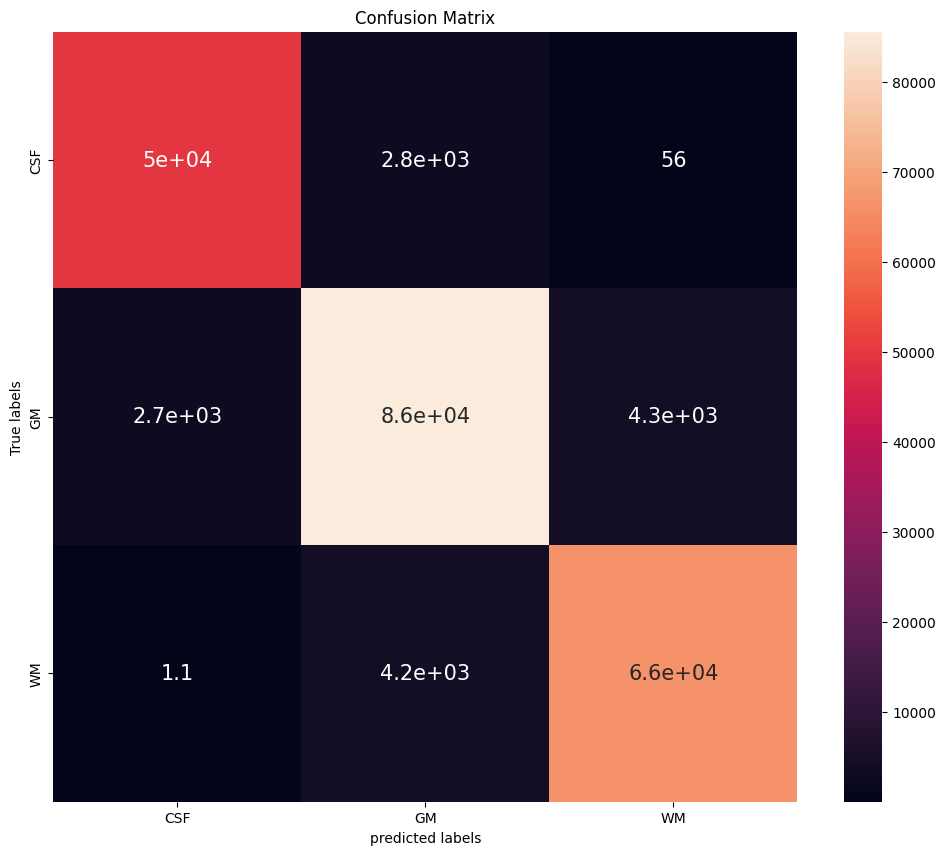

Batches in Train DataLoader: 62
Batches in Validation DataLoader: 21
Batches in Test DataLoader: 21
EPOCH 1/50 - Training Loss: 0.18040283168515853, Training Pearson score: 0.7035064330462417, Validation Loss: 0.14043603056953066, Validation Pearson Coefficient: 0.8406687458555976
EPOCH 2/50 - Training Loss: 0.11185103630827319, Training Pearson score: 0.8773504090913293, Validation Loss: 0.09116138163067046, Validation Pearson Coefficient: 0.9095838138763639
EPOCH 3/50 - Training Loss: 0.07757720038775474, Training Pearson score: 0.9216922538022675, Validation Loss: 0.06603285457406725, Validation Pearson Coefficient: 0.9356498555423255
EPOCH 4/50 - Training Loss: 0.05840661370706174, Training Pearson score: 0.9397526373048499, Validation Loss: 0.051382818924529214, Validation Pearson Coefficient: 0.9478222313627882
EPOCH 6/50 - Training Loss: 0.03874574181052946, Training Pearson score: 0.9563232258593934, Validation Loss: 0.035379619825453984, Validation Pearson Coefficient: 0.96061

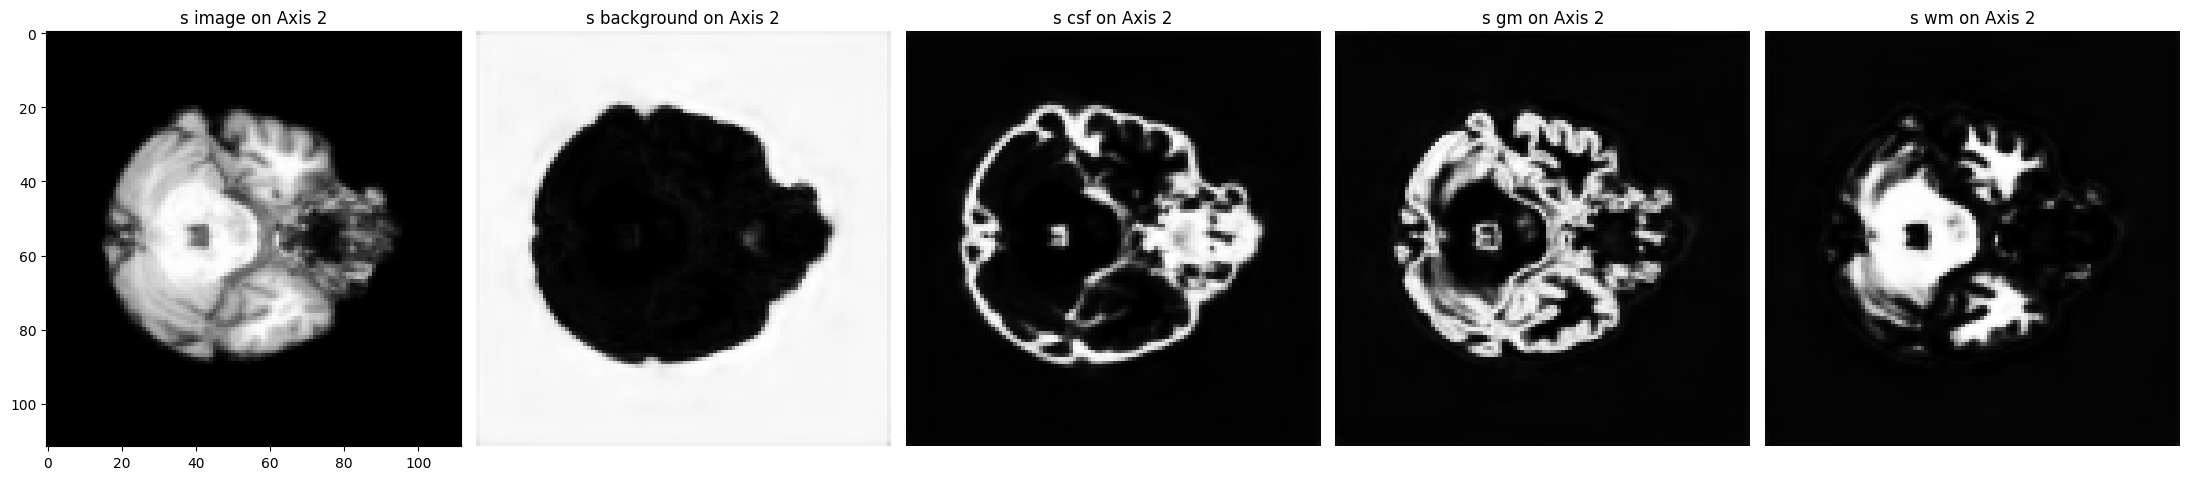

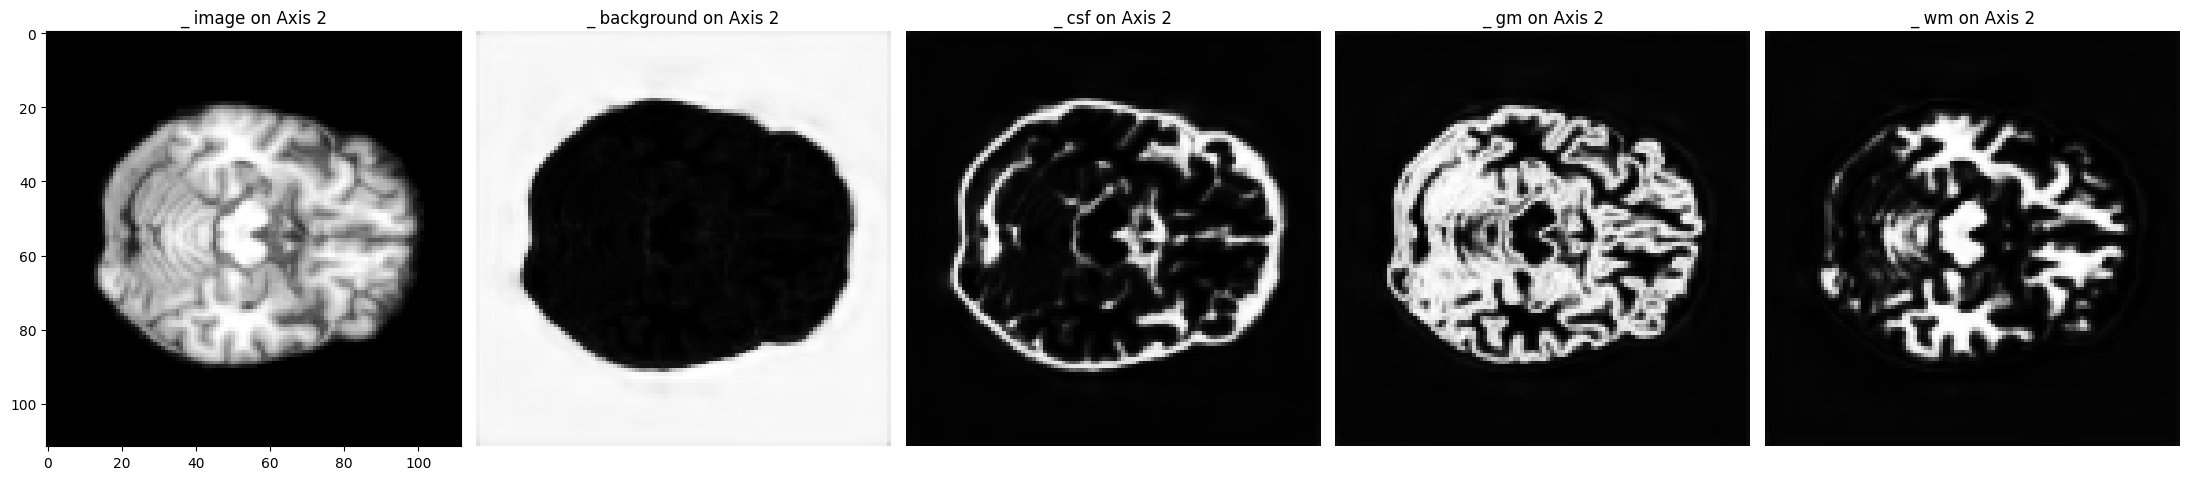

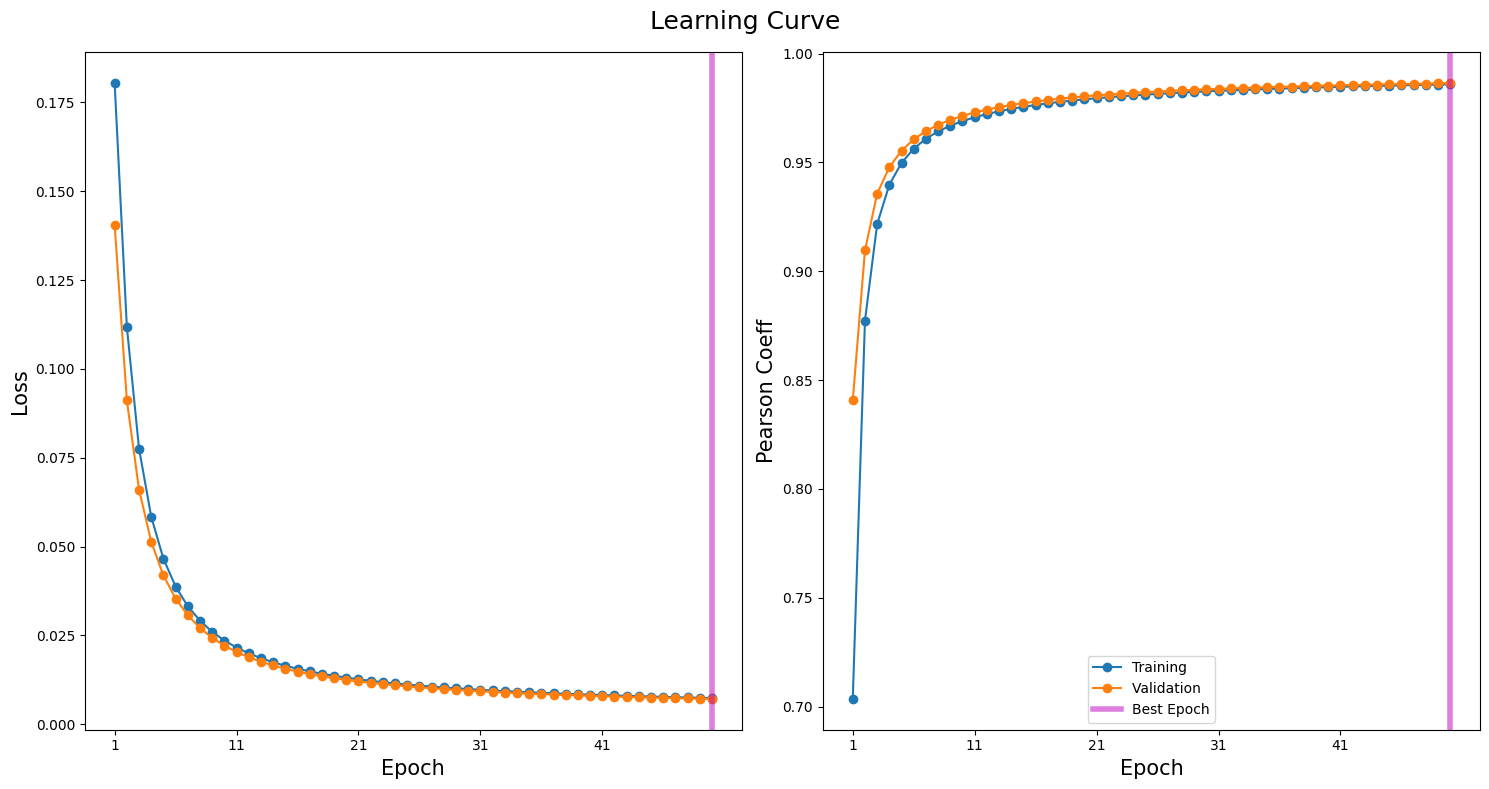

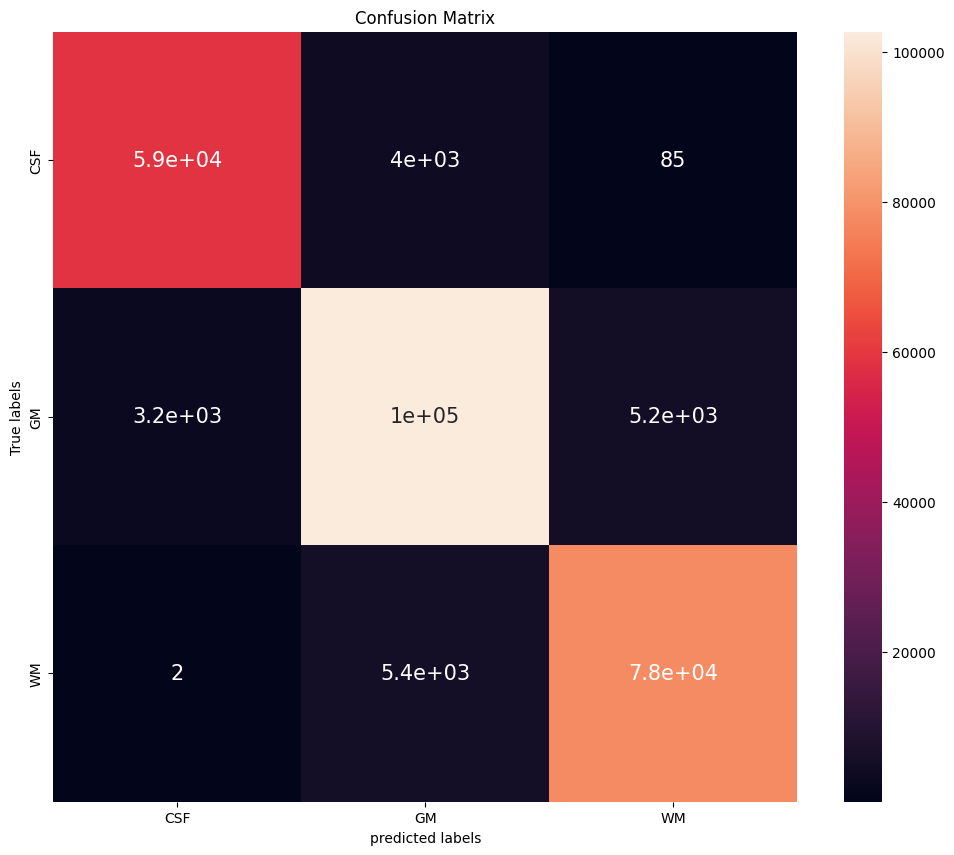

In [11]:
#make directory to save figures in 
if not os.path.isdir("figures"):
    os.mkdir("figures")
save_root_folder = "/kaggle/working/figures"
final_predictions = list()
final_labels = list()
final_images = list()

for axis in range(3):
    torch.manual_seed(1102)
    np.random.seed(1102) #Q: should i reset the seeds each time?
    root_folder = f"/kaggle/input/axis-{axis}-slices"

    #2: datasets and dataloaders
    percent = 1
    train_dataset = BasicDataset(root_folder, 'train', percent)
    valid_dataset = BasicDataset(root_folder, 'valid', percent)
    test_dataset = BasicDataset(root_folder, 'test', percent)

    batch_size = 85
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_loader = DataLoader(valid_dataset, batch_size = batch_size)
    test_loader = DataLoader(test_dataset, batch_size = batch_size)
    
    print (f"Batches in Train DataLoader: {len(train_loader)}")
    print (f"Batches in Validation DataLoader: {len(valid_loader)}")
    print (f"Batches in Test DataLoader: {len(test_loader)}")

    #display the first five image slices
#     for slc in range (5):
#         plot_image(train_dataset[slc]['mask'], train_dataset[slc]['image'], train_dataset[slc]['sbj_id'], axis, save_root_folder)
    
    #create instance of u-net architecture
    model = UNet(f"Model_Axis_{axis}", 1, 4)
    model = model.cuda()
    
        
    #4: define loss function and optimization method
    #define optimizer 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    

    #define loss function
    criterion = nn.MSELoss(reduction = "sum")
    
    
    #5: train the model for at least 50 epochs 
    #6: validate and save the model at the end of each epoch
    EPOCHS = 50
    train_loss, train_pearson, valid_loss, valid_pearson = train_net(model, EPOCHS, train_loader, valid_loader, optimizer, loss_function)

    
    #7: choose the best epoch and load the weights at that specific epoch
    best_epoch = np.argmax(valid_pearson) + 1 #just add one bc epochs start at 1
    print (f"Best Epoch: {best_epoch}")

    #load weights to model
    state_dict = torch.load(f'./Model_Axis_{axis}/epoch_{best_epoch:03}.pth')
    torch.save(state_dict, f"/kaggle/working/Axis_{axis}_model_best_epoch.pth")
    !rm -r './Model_Axis_{axis}'
    model.load_state_dict(state_dict)
    model.cuda()
    

    #8: test the model on the test data
    test_imgs, test_labels, test_predictions, test_loss, test_dice, test_pearson, test_CM = test_net(model, test_loader, loss_function)
    final_predictions.append(test_predictions)
    final_labels.append(test_labels)
    final_images.append(test_imgs)
    print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Pearson Correlation: {test_pearson}')
    
    for slc in range (3, 5):
        plot_image(test_predictions[0][slc], test_imgs[0][slc], test_labels[0][slc], axis)

    
    #9: generate and save all the figures you might need for the presentation (dataset distribution, learning curve, confusion matrix, etc.)
    learning_curve(best_epoch, train_loss, valid_loss, train_pearson, valid_pearson, save_root_folder)
    CM(test_CM, save_root_folder, f"Axis {axis}")
                    
    model = model.cpu() #remove old model from gpu